# Isogeometric analysis of the non-linear time-dependent Poisson equation using the implicit time step.

#### In this section, we test Newton's method and implicit time scheme.

## 1. Nonlinear Poisson Equation

  Let $\Omega\subset\mathbb{R}^d$ be an open set with sufficiently smooth boundary, denoted by $\Gamma$, where $d$ is the number of spatial dimensions. Then, the problem stated in strong form as :

Find $\mathbf{c} :\overline{\Omega}\times(0,T)\longmapsto\mathbb{R}$ such that 
## $	\begin{align*}
		\left\lbrace\begin{array}{lll}
			\dfrac{\partial \mathbf{c}}{\partial t} ~~~~~=~ \nabla \cdot \big( (1 + \mathbf{c}^2)\nabla\mathbf{c}\big)  + f&\text{ in } \Omega\times(0,T) ,~~~~~~~~~~(1)\\
		    \mathbf{c}~~~~~~~~ =~ g &\text{ on } \Gamma_g\times(0,T),~~~~~~~~(2)\\
            \mathbf{c}(x,0)  = \mathbf{c}_0(x) &\text{ in } \overline{\Omega},~~~~~~~~~~~~~~~~~~~~~~~~(5)\\         
		\end{array}\right.
	\end{align*}$

## 2. Variational form and semidiscrete formulation

Let X be the functional space and $\big(.,.\big)_\Omega$ denote the $L^2$ inner product with respect to  $\Omega$. The variational formulation is stated as follows :

Find $\mathbf{c}\in X$, such that $\forall~w\in X$ : 

$$\textbf{B}\big(w;\mathbf{c},\mathbf{c}\big) = \mathbf{L}(w) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(8)$$

with

$$\begin{align*}\textbf{B}\big(w;\mathbf{c},v\big) &= \big(\nabla
w,(1+\mathbf{v})\nabla\mathbf{c}\big)_\Omega.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(9)\\
\textbf{L}\big(w\big) &= \big(w,f\big)_\Omega .~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)
\end{align*}$$

The space discretization of (11) leads to the following variational problem over the finite element spaces : 

Find $\mathbf{c}^h \in X^h\subset X$, such that $\forall~w^h \in X^h$ : 

$$\textbf{B}\big(w^h;\mathbf{c}^h, \mathbf{c}^h\big) = 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(10)$$

where 

$$\mathbf{c}^h = \sum_{i=1}^{n_b} \mathbf{c}_iN_i, ~~~ w^h = \sum_{i=1}^{n_b} w_iN_i~~~~~~~~~~~~~~~~~~(11)$$

$n_b$ is the dimension of discrete space.

## 3. Newton Method

Let's define 
$$
F(v;u) := G(v;u,u) -l(v), \quad \forall v \in \mathcal{V}
$$

Newton method writes

$$
\mbox{Find } \mathbf{c}_{k+1} \in \mathcal{V}_h, \mbox{such that}\\
F^{\prime}(\delta \mathbf{c},v; \mathbf{c}_k) = - F(v;\mathbf{c}_k), \quad \forall v \in \mathcal{V} \\
\mathbf{c}_{k+1} := \mathbf{c}_{k} + \delta \mathbf{c}, \quad \delta \mathbf{c} \in \mathcal{V}
$$

 **c**. Update the iterates as 
 
  $$ \mathbf{c}_{n+1}       = \mathbf{c}_{k+1}$$

This complites one nonlinear iteration. The tolerance is given by reducing residual $\mathbf{R}$ to $10^{-3}$ or $10^{-4}$.

# 5. Numerical implementation under psydac.

$\textit{TODO}$

In [19]:
from sympy import pi, cos, sin, exp, symbols
from sympy.utilities.lambdify import implemented_function
import pytest

from sympde.calculus import grad, dot
from sympde.calculus import laplace
from sympde.topology import ScalarFunctionSpace
from sympde.topology import element_of
from sympde.topology import NormalVector
from sympde.topology import Square
from sympde.topology import Union
from sympde.expr     import BilinearForm, LinearForm, integral
from sympde.expr     import Norm
from sympde.expr     import find, EssentialBC
from sympde.expr.expr import linearize
from sympde.core     import Constant

from psydac.fem.basic          import FemField
from psydac.api.discretization import discretize

x,y,z = symbols('x1, x2, x3')

In [20]:
# ..Topological domain
domain = Square()
B_dirichlet_0 = domain.boundary

In [21]:
# ..Function Space
V  = ScalarFunctionSpace('V', domain)

In [22]:
# .. Defining the Linear form $G$
u  = element_of(V, name='u')
v  = element_of(V, name='v')
w  = element_of(V, name='w')

# time step
t = Constant(name='t')
dt = Constant(name='dt')
u0 = element_of(V, name='u0') 

# Linear form g: V --> R
g = LinearForm(v, integral(domain, u*v + dt * (1+ w**2)*dot(grad(u), grad(v))))

In [24]:
# ..SEVERAL EXAMPLES
u_0      = sin(pi*x)*sin(pi*y**2)*exp(0.01)
f        = 4.04020066833667*pi**2*y**2*(1.0 + 1.02020134002676*exp(-2*t)*sin(pi*x)**2*sin(pi*y**2)**2)*exp(-t)*sin(pi*x)*sin(pi*y**2) - 8.24363627162813*pi**2*y**2*exp(-3*t)*sin(pi*x)**3*sin(pi*y**2)*cos(pi*y**2)**2 + 1.01005016708417*pi**2*(1.0 + 1.02020134002676*exp(-2*t)*sin(pi*x)**2*sin(pi*y**2)**2)*exp(-t)*sin(pi*x)*sin(pi*y**2) - 2.02010033416834*pi*(1.0 + 1.02020134002676*exp(-2*t)*sin(pi*x)**2*sin(pi*y**2)**2)*exp(-t)*sin(pi*x)*cos(pi*y**2) - 1.01005016708417*exp(-t)*sin(pi*x)*sin(pi*y**2) - 2.06090906790703*pi**2*exp(-3*t)*sin(pi*x)*sin(pi*y**2)**3*cos(pi*x)**2

In [25]:
# Linear form l: V --> R
l = LinearForm(v, integral(domain, u0 * v + dt * f * v))

In [26]:
F = LinearForm(v, g(v,w=u)-l(v))
du  = element_of(V, name='du')

# ...
Fprime = linearize(F, u, trials=du)

In [27]:
un  = element_of(V, name='un')

# Bilinear form a: V x V --> R
a = BilinearForm((u, v), g(v, u=u,w=un))

In [28]:
# Dirichlet boundary conditions
bc = [EssentialBC(du, 0, B_dirichlet_0)]

# Variational problem
equation   = find(du, forall=v, lhs=Fprime(du, v,u=un), rhs=-F(v,u=un), bc=bc)

In [29]:
# Create computational domain from topological domain
domain_h = discretize(domain, ncells=[32, 32], comm=None)

# Discrete spaces
Vh = discretize(V, domain_h, degree=[2,2])

# Discretize equation using Dirichlet bc
equation_h = discretize(equation, domain_h, [Vh, Vh])

In [30]:

def Time_dependent_Poisson(dt_h, nt, u0_h, niter=10):

    Tf             = dt_h*(nt+1)
    t_h            = 0.
    Un             = FemField( Vh, Vh.vector_space.zeros() )
    Un.coeffs[:,:] = u0_h.coeffs[:,:]
    # ..at first iteration
    solution = sin(pi*x)*sin(pi*y**2)*exp(0.01-t_h)
    # ...For t>t0
    while t_h < Tf :
        t_h += dt_h
        solution = sin(pi*x)*sin(pi*y**2)*exp(0.01-t_h)
        # .. update u0
        u0_h.coeffs[:,:] = Un.coeffs[:,:]    
        # .. Newton Method
        for i in range(niter):
            delta_x  = equation_h.solve(un=Un, u0 = u0_h, dt = dt_h, t = t_h)
            Un = FemField( Vh, delta_x.coeffs + Un.coeffs )
  
            # Error norms
            error  = u - solution
            l2norm = Norm(error, domain, kind='l2')
            # Discretize error norms
            l2norm_h = discretize(l2norm, domain_h, Vh)
            # Compute error norms 
            l2_error = l2norm_h.assemble(u=Un)    

        print('l2_error = ', l2_error)
        
    return Un

In [31]:
#.. computes the projection of u_0 in the space
a_app = BilinearForm((u, v),integral(domain,u*v))  
l_app = LinearForm(v, integral(domain, u_0 * v) )
#..
equation_app = find(u, forall=v, lhs=a_app(u, v), rhs=l_app(v))
#..
equation_app_h = discretize(equation_app, domain_h, [Vh, Vh])
# Solve linear system
u0_h = equation_app_h.solve()
# Error norms
error  = u - u_0
l2norm = Norm(error, domain, kind='l2')
# Discretize error norms
l2norm_h = discretize(l2norm, domain_h, Vh)
print('le-error = ', l2norm_h.assemble(u=u0_h))

le-error =  7.37830296868844e-06


In [32]:
dt_h     = 0.01
nt       = 3
un = Time_dependent_Poisson(dt_h, nt, u0_h, niter=20)

l2_error =  1.7556815738972338e-05
l2_error =  2.6312814766572693e-05
l2_error =  3.340880244121601e-05
l2_error =  3.9081380054826424e-05


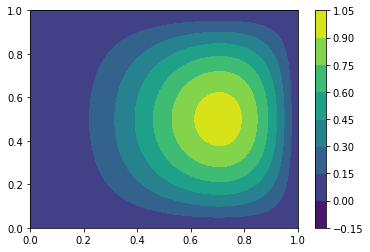

In [33]:
from matplotlib import pyplot as plt
from simplines import plot_field_2d
nbasis = [w.nbasis for w in Vh.spaces]
p1,p2 = Vh.degree
x = un.coeffs._data[p1:-p1,p2:-p2]
u = x.reshape(nbasis)
plot_field_2d(Vh.knots, Vh.degree, u) ; plt.colorbar()